# Ejercicio 12: Multimodal Embeddings

## Objetivo de la práctica

El objetivo de este ejercicio es observar cómo modelos multimodales como CLIP llevan texto e imágenes al mismo espacio vectorial, y verificar graficando embeddings en 2D.

### Pasos:

1. Obtener embeddings de imágenes y textos con CLIP.
2. Mostrar que ambos viven en el mismo espacio (misma dimensión y comparables).
3. Proyectar los vectores a 2D (PCA / t-SNE / UMAP) y graficarlos en un plano.
4. Verificar emparejamientos usando cosine similarity (búsqueda texto→imagen e imagen→texto).

In [1]:
!pip install torch torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install scikit-learn matplotlib pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-85esy_5o
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-85esy_5o
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=1750b4af9df6112490a1248c9067c37c9a9ae83d32a0b3d5f74ee48f9ade17c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-sbjdqwyx/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


Configuración del Entorno e Importaciones. Carga de las librerías necesarias

In [3]:
# --- Carga de modelos y procesamiento de Tensores ---
# Torch es la base para deep learning y clip es el modelo de OpenAI para conectar texto e imágenes.
import torch
import clip

# --- Manipulación de datos y visualización ---
# Bibliotecas estándar para manejo de arreglos numéricos y generación de gráficos.
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Reducción de dimensionalidad ---
# Herramientas para proyectar vectores de alta dimensión (embeddings) en espacios de 2D o 3D.
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- Métricas y utilidades de red ---
# Cosine similarity permite medir qué tan parecidos son dos vectores.
# Urllib se usará para descargar imágenes desde enlaces externos.
from sklearn.metrics.pairwise import cosine_similarity
import urllib.request

Configuración del Dispositivo y Carga del Modelo

In [4]:
# --- Configuración del hardware ---
# Si hay una GPU disponible, la usamos para acelerar las operaciones matemáticas.
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Inicialización del modelo CLIP ---
# Cargamos los pesos del modelo Vision Transformer (ViT) y la función de preprocesamiento.
model, preprocess = clip.load("ViT-B/32", device=device)

# --- Confirmación ---
# Mostramos en pantalla qué dispositivo se asignó finalmente.
print("Dispositivo:", device)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 55.8MiB/s]


Dispositivo: cuda


Adquisición de Datos (Imágenes)

En este paso, definimos un diccionario de imágenes provenientes de **Unsplash**. Las imágenes están categorizadas en grupos (animales, vehículos, personas y comida) para evaluar cómo **CLIP** genera vectores similares para objetos de la misma clase.

In [5]:
image_urls = {
    # Perros
    "perro1.jpg": "https://images.unsplash.com/photo-1517849845537-4d257902454a",
    "perro2.jpg": "https://images.unsplash.com/photo-1558788353-f76d92427f16",

    # Gatos
    "gato1.jpg": "https://images.unsplash.com/photo-1518791841217-8f162f1e1131",
    "gato2.jpg": "https://images.unsplash.com/photo-1595433707802-6b2626ef1c91",

    # Autos
    "auto1.jpg": "https://images.unsplash.com/photo-1503376780353-7e6692767b70",
    "auto2.jpg": "https://images.unsplash.com/photo-1549924231-f129b911e442",

    # Aviones
    "avion1.jpg": "https://images.unsplash.com/photo-1529070538774-1843cb3265df",
    "avion2.jpg": "https://images.unsplash.com/photo-1436491865332-7a61a109cc05",

    # Personas
    "persona1.jpg": "https://images.unsplash.com/photo-1500648767791-00dcc994a43e",
    "persona2.jpg": "https://images.unsplash.com/photo-1529626455594-4ff0802cfb7e",

    # Comida
    "comida1.jpg": "https://images.unsplash.com/photo-1546069901-ba9599a7e63c",
    "comida2.jpg": "https://images.unsplash.com/photo-1504674900247-0877df9cc836",
}

image_paths = []

for name, url in image_urls.items():
    urllib.request.urlretrieve(url + "?w=640", name)
    image_paths.append(name)

len(image_paths)


12

Extracción de Características (Embeddings). Se transforman las imágenes descargadas en **vectores numéricos (embeddings)**.

In [6]:
# --- Preprocesamiento de imágenes ---
# Convertir cada archivo en un tensor listo para el modelo (Resize, CenterCrop, ToTensor, Normalize)
images = [
    preprocess(Image.open(p).convert("RGB")).unsqueeze(0).to(device)
    for p in image_paths
]

# --- Generación de Embeddings ---
# Uso torch.no_grad()solo extrayendo datos.
with torch.no_grad():
    # Concatenar los resultados de codificar cada imagen individualmente
    image_embeddings = torch.cat([model.encode_image(img) for img in images])

# --- Normalización de vectores ---
# Dividir cada embedding por su norma para proyectarlos
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)


# El resultado será una matriz de [n_imagenes, 512]
print("Embeddings de imágenes:", image_embeddings.shape)

Embeddings de imágenes: torch.Size([12, 512])


Procesamiento de Texto y Alineación Semántica. Ahora se genera los embeddings para una lista de etiquetas textuales.

In [7]:
# Lista de conceptos que se quiere comparar con nuestras imágenes descargadas.
texts = [
    "dog",
    "cat",
    "car",
    "airplane",
    "a person with lazy hair and brown",
    "a person white",
    "food"
]

# Texto en tokens compatibles con el vocabulario de CLIP.
text_tokens = clip.tokenize(texts).to(device)
# Extraer los embeddings del codificador de lenguaje (Transformer).
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)

# --- Normalización --
text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

# El resultado será una matriz de [n_textos, 512].
print("Embeddings de texto:", text_embeddings.shape)

Embeddings de texto: torch.Size([7, 512])


Comprobar las dimensiones

In [8]:
print("Dimensión imagen:", image_embeddings.shape[1])
print("Dimensión texto:", text_embeddings.shape[1])


Dimensión imagen: 512
Dimensión texto: 512


Cálculo de Similitud de Coseno.**Afinidad semántica** entre cada descripción de texto y cada imagen.

In [9]:
# --- Cálculo de Similitud ---
similarity = cosine_similarity(
    text_embeddings.cpu().numpy(),
    image_embeddings.cpu().numpy()
)

# --- Resultado ---
similarity

array([[0.28785478, 0.27026351, 0.21082499, 0.22754475, 0.17811066,
        0.17522779, 0.16644613, 0.17360936, 0.20899203, 0.18655418,
        0.15800089, 0.14338189],
       [0.22692529, 0.18392974, 0.26145286, 0.27236906, 0.19174137,
        0.17007713, 0.16494284, 0.17062084, 0.19575878, 0.20973565,
        0.14912205, 0.13759741],
       [0.21247263, 0.18733226, 0.18000131, 0.20410218, 0.25177337,
        0.19406847, 0.16200774, 0.17929308, 0.21463064, 0.21830206,
        0.18560011, 0.15117113],
       [0.20115653, 0.17899692, 0.17053285, 0.18629807, 0.17705131,
        0.1397812 , 0.15661649, 0.23975266, 0.15844477, 0.2088644 ,
        0.16641202, 0.13942153],
       [0.22170183, 0.22118348, 0.20708186, 0.21026656, 0.17575684,
        0.18682798, 0.19308875, 0.16918658, 0.2614874 , 0.26259184,
        0.14999645, 0.15585236],
       [0.22968784, 0.21706206, 0.20161209, 0.21626431, 0.18722708,
        0.19701763, 0.20949839, 0.19615369, 0.2590592 , 0.24009776,
        0.17064568,

Aquí reducimos las dimensiones de los embeddings usando PCA o TSNE a 2 dimensiones para poder graficarlos con pyplot.

In [10]:
# --- Preparación de datos conjuntos ---
# Unimos embeddings de imágenes y textos en una sola matri
all_embeddings = torch.cat([image_embeddings, text_embeddings]).cpu().numpy()

# --- Aplicación de PCA ---
pca = PCA(n_components=2, n_oversamples=12)
embeddings_2d_pca = pca.fit_transform(all_embeddings)

img_2d_pca = embeddings_2d_pca[:len(image_embeddings)]
txt_2d_pca = embeddings_2d_pca[len(image_embeddings):]

tsne = TSNE(n_components=2, perplexity=12, random_state=42)
embeddings_2d_tsne = tsne.fit_transform(all_embeddings)

img_2d_tsne = embeddings_2d_tsne[:len(image_embeddings)]
txt_2d_tsne = embeddings_2d_tsne[len(image_embeddings):]

Visualización de Resultados: Scatter Plot t-SNE

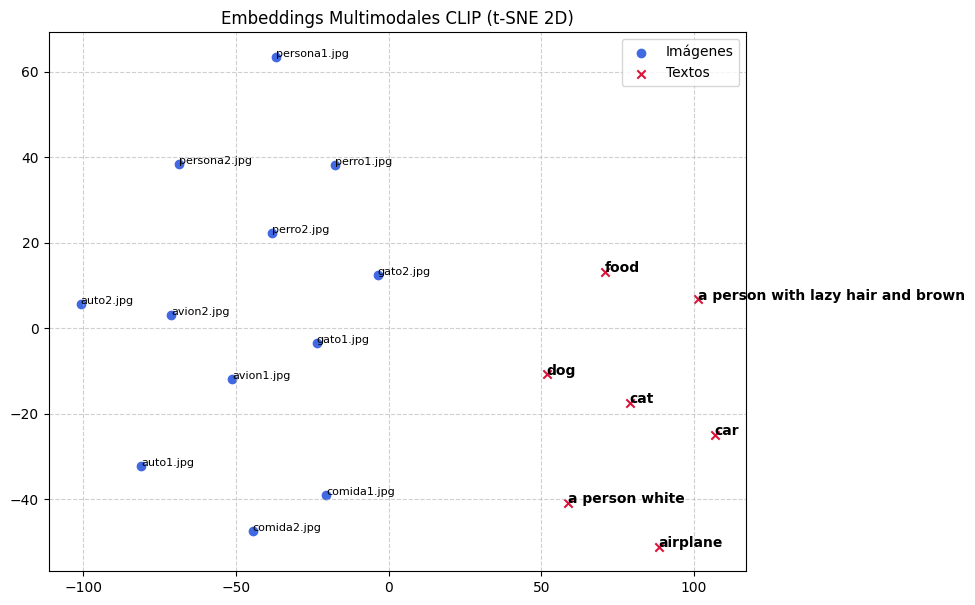

In [11]:
# --- Configuración del lienzo ---
plt.figure(figsize=(9,7))

# Círculos para identificar las imágenes y añadimos el nombre del archivo como etiqueta.
plt.scatter(img_2d_tsne[:,0], img_2d_tsne[:,1], marker='o', label='Imágenes', color='royalblue')
for i, name in enumerate(image_paths):
    plt.text(img_2d_tsne[i,0], img_2d_tsne[i,1], name, fontsize=8)

plt.scatter(txt_2d_tsne[:,0], txt_2d_tsne[:,1], marker='x', label='Textos', color='crimson')
for i, txt in enumerate(texts):
    plt.text(txt_2d_tsne[i,0], txt_2d_tsne[i,1], txt, fontsize=10, fontweight='bold')

# --- Estética y Detalles del Gráfico ---
plt.title("Embeddings Multimodales CLIP (t-SNE 2D)")
plt.legend() # Muestra la leyenda de imágenes vs textos
plt.grid(True, linestyle='--', alpha=0.6) # Añade una cuadrícula ligera
plt.show() # Despliega la gráfica final

Visualización de Resultados: Proyección PCA

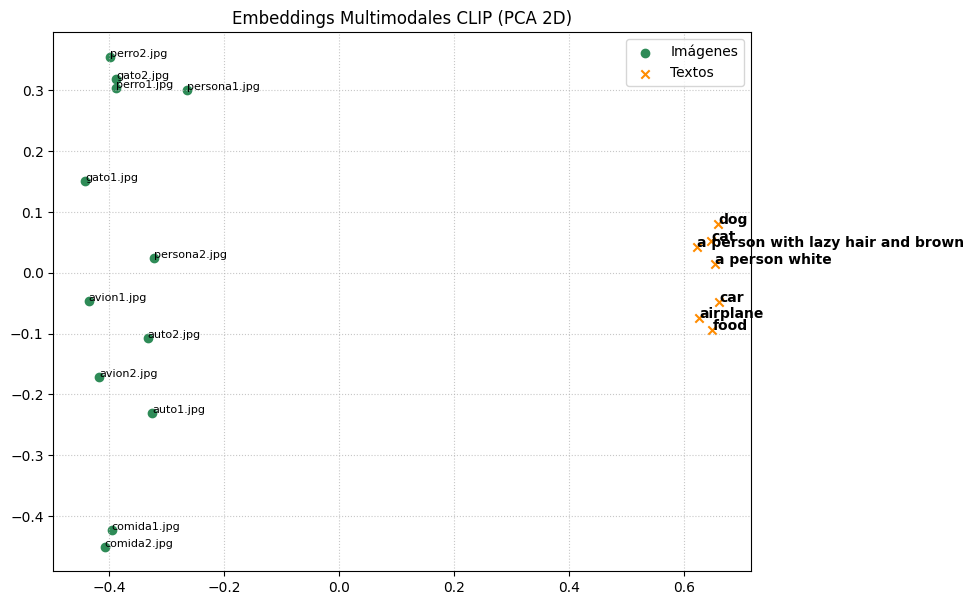

In [12]:
# --- Configuración del lienzo para PCA ---
plt.figure(figsize=(9,7))

# --- Graficar proyecciones de Imágenes (PCA) ---
plt.scatter(img_2d_pca[:,0], img_2d_pca[:,1], marker='o', label='Imágenes', color='seagreen')
for i, name in enumerate(image_paths):
    plt.text(img_2d_pca[i,0], img_2d_pca[i,1], name, fontsize=8)

# --- Graficar proyecciones de Textos (PCA) ---
plt.scatter(txt_2d_pca[:,0], txt_2d_pca[:,1], marker='x', label='Textos', color='darkorange')
for i, txt in enumerate(texts):
    plt.text(txt_2d_pca[i,0], txt_2d_pca[i,1], txt, fontsize=10, fontweight='bold')

# --- Detalles finales del gráfico ---
plt.title("Embeddings Multimodales CLIP (PCA 2D)")
plt.legend() # Muestra la distinción entre círculos y cruces
plt.grid(True, linestyle=':', alpha=0.7) # Cuadrícula punteada para mejor lectura
plt.show() # Renderiza el gráfico de PCA

Motor de Búsqueda Semántica (Zero-Shot)

In [14]:
def buscar_imagen(texto):
    """
    Recibe una cadena de texto, busca la imagen más parecida
    dentro de nuestro dataset y la visualiza.
    """
    # Tokenizamos y movemos al dispositivo (GPU/CPU)
    token = clip.tokenize([texto]).to(device)

    with torch.no_grad():
        emb = model.encode_text(token)
        emb /= emb.norm(dim=-1, keepdim=True)

    # --- Cálculo de relevancia ---
    # Comparar el embedding del texto contra todos los de las imágenes
    scores = cosine_similarity(
        emb.cpu().numpy(),
        image_embeddings.cpu().numpy()
    )[0]


    # Obtener el índice de la imagen que obtuvo el puntaje más alto
    idx = np.argmax(scores)

    # --- Visualización ---
    print(f"Consulta: '{texto}'")
    print(f"Resultado óptimo: {image_paths[idx]} (Score: {scores[idx]:.4f})")


    plt.imshow(Image.open(image_paths[idx]))
    plt.axis("off") # Ocultar los ejes para una vista limpia
    plt.show()

Clasificación de Imágenes (Image-to-Text)

In [15]:
def buscar_texto(nombre_imagen):
    """
    Dada la ruta de una imagen, encuentra qué texto de nuestra lista
    describe mejor su contenido visual.
    """
    # Convertir a RGB y aplicar las transformaciones de CLIP
    img = preprocess(Image.open(nombre_imagen).convert("RGB")).unsqueeze(0).to(device)

    # --- Extracción de características visuales ---
    with torch.no_grad():
        emb = model.encode_image(img)
        emb /= emb.norm(dim=-1, keepdim=True)

    # --- Comparación contra la lista de textos ---
    scores = cosine_similarity(
        emb.cpu().numpy(),
        text_embeddings.cpu().numpy()
    )[0]

    # --- Ranking de resultados ---
    text_scores = zip(texts, scores)
    text_scores = sorted(text_scores, key=lambda x: x[1], reverse=True)

    print("Ranking de etiquetas y puntajes:")
    for txt, score in text_scores:
        print(f" - {txt}: {score:.4f}")

    # Obtener el índice del puntaje máximo (el ganador)
    idx = np.argmax(scores)

    print("\n" + "="*30)
    print("Imagen:", nombre_imagen)
    print("Predicción principal:", texts[idx])


    plt.imshow(Image.open(nombre_imagen))
    plt.axis("off")
    plt.show()

Consulta: 'motor'
Resultado óptimo: auto1.jpg (Score: 0.2337)


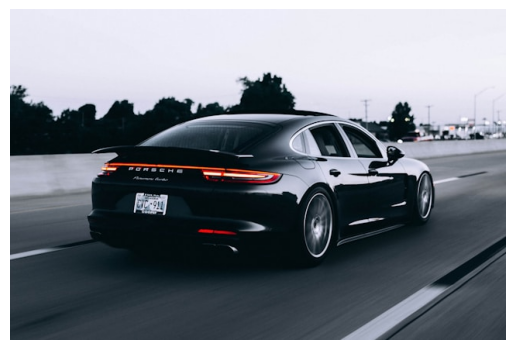

In [17]:
#Prueba de Concepto: Búsqueda de "Motor"
buscar_imagen("motor")

Ranking de etiquetas y puntajes:
 - food: 0.2422
 - car: 0.1856
 - a person white: 0.1706
 - airplane: 0.1664
 - dog: 0.1580
 - a person with lazy hair and brown: 0.1500
 - cat: 0.1491

Imagen: /content/comida1.jpg
Predicción principal: food


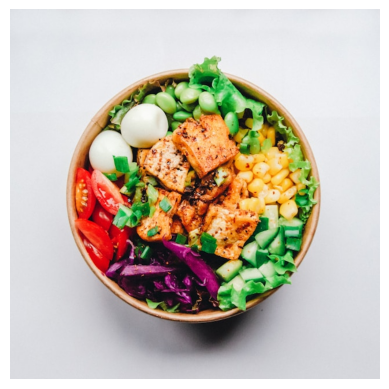

In [20]:
buscar_texto("/content/comida1.jpg")